In [ ]:
import math
import numpy as np
from pprint import pprint
import time

class SolverAssignment:
    def __init__(self, C, d, e):
        self.C = np.array(C)
        self.d = np.array(d)
        self.e = np.array(e)

        self.C1 = np.copy(C/2)
        self.C2 = np.copy(C/2)

        self.C1_final = None
        self.C2_final = None

    @staticmethod
    def solve_1d(c, d_k, k=0):
        #k от 1 до 2n, от n+1 до 2n - уже e_m
        c_min = min(np.min(c), d_k)
        c_j_mins = np.where(c == c_min)[0]
        is_d = 1 if c_min == d_k else 0
        return {
            "c_j": list(c_j_mins),
            "is_d": is_d,
            "equal": 1
        }

    @staticmethod
    def solve_2d(c1_ini, c2_ini, d_k, e_m, k=0, m=0):
        const_inf = int(10**6)

        c1 = c1_ini.copy()
        c2 = c2_ini.copy()

        c_km = c1[m] + c2[k]

        c1[m] = const_inf
        c2[k] = const_inf

        c1_min, c1_min_j = np.min(c1), np.argmin(c1)
        c2_min, c2_min_i = np.min(c2), np.argmin(c2)

        coefs = np.array([c1_min + c2_min, c1_min + e_m, d_k + c2_min, d_k + e_m])
        coef, coef_case = np.min(coefs), np.argmin(coefs)

        c1_min_coef, c2_min_coef = None, None
        if coef_case == 0:
            c1_min_coef, c2_min_coef = c1_min, c2_min
        elif coef_case == 1:
            c1_min_coef, c2_min_coef = c1_min, e_m
        elif coef_case == 2:
            c1_min_coef, c2_min_coef = d_k, c2_min
        elif coef_case == 3:
            c1_min_coef, c2_min_coef = d_k, e_m

        c_coefs_old = [c1_min_coef, c2_min_coef]
        min_coef, max_coef = (0, 1) if c_coefs_old[0] < c_coefs_old[1] else (1, 0)

        c_coefs_new = [None, None]

        if c_km < c1_min_coef + c2_min_coef:
            delta_ceil =  math.ceil((c1_min_coef + c2_min_coef - c_km) / 2)
            delta_floor = math.floor((c1_min_coef + c2_min_coef - c_km) / 2)

            if c_coefs_old[min_coef] - delta_floor < 1:
                c_coefs_new[min_coef] = 1
                c_coefs_new[max_coef] = c_km - 1
            else:
                c_coefs_new[min_coef] = c_coefs_old[min_coef] - delta_floor
                c_coefs_new[max_coef] = c_coefs_old[max_coef] - delta_ceil

        if c_km == c1_min_coef + c2_min_coef:
            c_coefs_new = list(c_coefs_old)

        elif c_km > c1_min_coef + c2_min_coef:
            delta_ceil =  math.ceil((c_km - (c1_min_coef + c2_min_coef)) / 2)
            delta_floor = math.floor((c_km - (c1_min_coef + c2_min_coef)) / 2)

            c_coefs_new[min_coef] = c_coefs_old[min_coef] + delta_ceil
            c_coefs_new[max_coef] = c_coefs_old[max_coef] + delta_floor

        return {
            "c1_km": c_coefs_new[0],
            "c2_km": c_coefs_new[1]
        }

    @staticmethod
    def solve_1d_final(C1, C2, d, e, is_log=False):

        M, N = C1.shape

        ans_c1 = {}
        ans_c2 = {}

        for i in range(0, M):
            cur_c = C1[i]
            cur_d = d[i]
            ans = SolverAssignment.solve_1d(c=cur_c, d_k=cur_d)
            ans_c1[i] = ans
            if is_log:
                eq_str = " + ".join([f'{int(cur_c[s])}x_{i+1}{s+1}' for s in range(0, N)]) + f" + {cur_d}y_{i+1}"
                ans_str = " + ".join([f'x_{i+1}{s+1}' for s in ans["c_j"]])
                ans_str += (" + " if (len(ans_str) > 1) & (ans["is_d"]) else "") + (f"y_{i+1}" if ans["is_d"] else "")
                print(f"{eq_str}->min\n"+
                      f"{ans_str} = 1\n")

        for j in range(0, N):
            cur_c = C2[:,j]
            cur_e = e[j]
            ans = SolverAssignment.solve_1d(c=cur_c, d_k=cur_e)
            ans_c2[j] = ans
            if is_log:
                eq_str = " + ".join([f'{int(cur_c[r])}*x_{r+1}{j+1}' for r in range(0, M)]) + f" + {cur_e}w_{j}"
                ans_str = " + ".join([f'x_{r+1}{j+1}' for r in ans["c_j"]])
                ans_str += (" + " if (len(ans_str) > 1) & (ans["is_d"]) else "") + (f"w_{j}" if ans["is_d"] else "")
                print(f"{eq_str}->min\n"
                      f"{ans_str} = 1\n")

        return {
            "ans_c1": ans_c1,
            "ans_c2": ans_c2
        }
    def solve_task(self, is_log=False):
        #TODO - решние 1D

        C1_cur, C2_cur = np.copy(self.C1), np.copy(self.C2)
        C1_prev, C2_prev = None, None

        M, N = C.shape
        cur_iter = 0
        while True:
            if (np.array_equal(C1_cur, C1_prev)) & (np.array_equal(C2_cur, C2_prev)):
                break

            C1_prev, C2_prev = np.copy(C1_cur), np.copy(C2_cur)
            for i in range(0, M):
                for j in range(0, N):
                    c1_ini = C1_cur[i]
                    c2_ini = C2_cur[:,j]
                    d_k, e_m = self.d[i], self.e[j]

                    result = self.solve_2d(c1_ini=c1_ini, c2_ini=c2_ini, d_k=d_k, e_m=e_m, k=i, m=j)
                    C1_cur[i, j] = result["c1_km"]
                    C2_cur[i, j] = result["c2_km"]

            cur_iter += 1
        self.C1_final = C1_cur
        self.C2_final = C2_cur

        return self.C1_final, self.C2_final

In [ ]:
C = [
    [8, 10, 12, 6, 4],
    [14, 16, 18, 4, 2],
    [20, 22, 24, 12, 10],
    [26, 28, 30, 14, 12],
    [32, 34, 36, 16, 14]
]
C = np.array(C)

d = [12, 14, 8, 18, 10]
e = [5, 7, 9, 11, 13]

sa = SolverAssignment(C, d, e)
C1_final, C2_final = sa.solve_task()
solve_final_1d = SolverAssignment.solve_1d_final(C1_final, C2_final, d, e, is_log=True)

3x_11 + 3x_12 + 3x_13 + 3x_14 + 3x_15 + 12y_1->min
x_11 + x_12 + x_13 + x_14 + x_15 = 1

5x_21 + 5x_22 + 5x_23 + 1x_24 + 1x_25 + 14y_2->min
x_24 + x_25 = 1

11x_31 + 11x_32 + 12x_33 + 8x_34 + 8x_35 + 8y_3->min
x_34 + x_35 + y_3 = 1

15x_41 + 15x_42 + 15x_43 + 10x_44 + 10x_45 + 18y_4->min
x_44 + x_45 = 1

18x_51 + 18x_52 + 18x_53 + 11x_54 + 11x_55 + 10y_5->min
y_5 = 1

5*x_11 + 9*x_21 + 9*x_31 + 11*x_41 + 14*x_51 + 5w_0->min
x_11 + w_0 = 1

7*x_12 + 11*x_22 + 11*x_32 + 13*x_42 + 16*x_52 + 7w_1->min
x_12 + w_1 = 1

9*x_13 + 13*x_23 + 12*x_33 + 15*x_43 + 18*x_53 + 9w_2->min
x_13 + w_2 = 1

3*x_14 + 3*x_24 + 4*x_34 + 4*x_44 + 5*x_54 + 11w_3->min
x_14 + x_24 = 1

1*x_15 + 1*x_25 + 2*x_35 + 2*x_45 + 3*x_55 + 13w_4->min
x_15 + x_25 = 1



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def power_law(x, a, p):
    return a * (x ** p)

def plot_complexity():
    dims1 = np.linspace(10, 101, 10, dtype=int)
    dims2 = np.linspace(110, 1000, 10, dtype=int)
    dims3 = np.linspace(1100, 10000, 10, dtype=int)
    #dims4 = np.linspace(11000, 15000, 10, dtype=int)

    x = np.concatenate([dims1, dims2, dims3], axis=0)
    y = []

    for N in x:
        M = N
        C = 2 * np.random.randint(1, 10000, size=(M, N))
        d = np.random.randint(1, 10000, size=M)
        e = np.random.randint(1, 10000, size=N)

        start_time = time.time()
        sa = SolverAssignment(C, d, e)
        C1_final, C2_final = sa.solve_task()
        solve_final_1d = SolverAssignment.solve_1d_final(C1_final, C2_final, d, e)
        ans_c1 = solve_final_1d["ans_c1"]
        ans_c2 = solve_final_1d["ans_c2"]

        end_time = time.time()
        y.append((end_time-start_time) * 1000)

    params, cov = curve_fit(power_law, x, y)
    a, p = params
    # Generate points for the fitted curve
    x_fit = np.linspace(min(x), max(x), 100)
    y_fit = power_law(x_fit, a, p)

    # Create the plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x=x, y=y, label='Original data', color='blue')
    sns.lineplot(x=x_fit, y=y_fit, label=f'Fitted curve: $Time = const*Dim^{{{p:.4f}}}$', color='red')

    sns.set_style("whitegrid")
    plt.xlabel('Размерность (M = N)')
    plt.ylabel('Время, мс')
    plt.title('Задача о назначениях с доп. работами и работниками')
    plt.legend()
    plt.grid(True)
    plt.show()

\begin{equation}
\sum_{i=1}^n x_{ij} + y_i = 1, \quad 1 \leq i \leq n
\end{equation}

\begin{equation}
\sum_{i=1}^n x_{ij} + w_j = 1, \quad 1 \leq j \leq n
\end{equation}

\begin{equation}
\sum_{i=1}^n \sum_{j=1}^n c_{ij}x_{ij} + \sum_{i=1}^n d_i y_i + \sum_{j=1}^n e_j w_j \to \min
\end{equation}

\begin{equation}
x_{ij}, w_{j}, y_i \in \{0,1\}, \quad c_{ij} \geq 0, \quad d_i \geq 0, \quad e_j \geq 0
\end{equation}

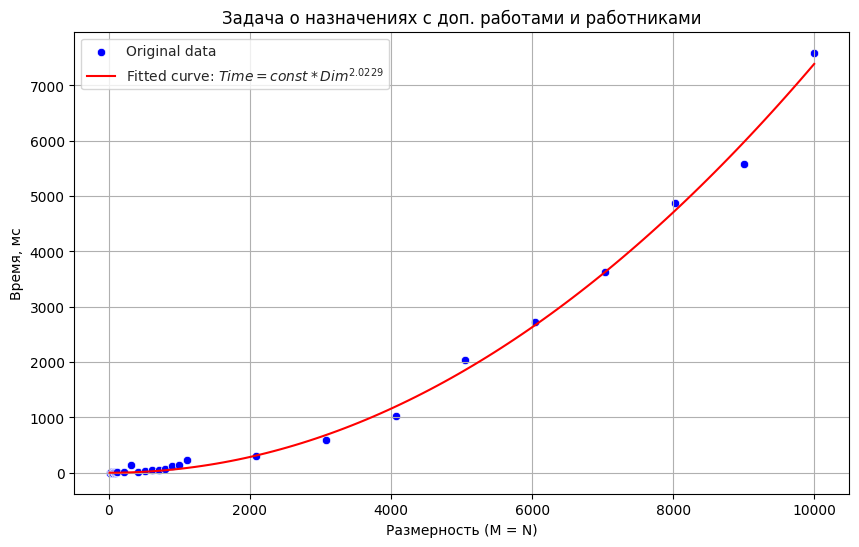

In [ ]:
plot_complexity()

\begin{equation}
\sum_{i=1}^n x_{ij} + y_i = 1, \quad 1 \leq i \leq n
\end{equation}

\begin{equation}
\sum_{i=1}^n x_{ij} + w_j = 1, \quad 1 \leq j \leq n
\end{equation}

\begin{equation}
\sum_{i=1}^n \sum_{j=1}^n c_{ij}x_{ij} + \sum_{i=1}^n d_i y_i + \sum_{j=1}^n e_j w_j \to \min
\end{equation}

\begin{equation}
x_{ij}, w_{j}, y_i \in \{0,1\}, \quad c_{ij} \geq 0, \quad d_i \geq 0, \quad e_j \geq 0
\end{equation}
